34.946815898977924


0

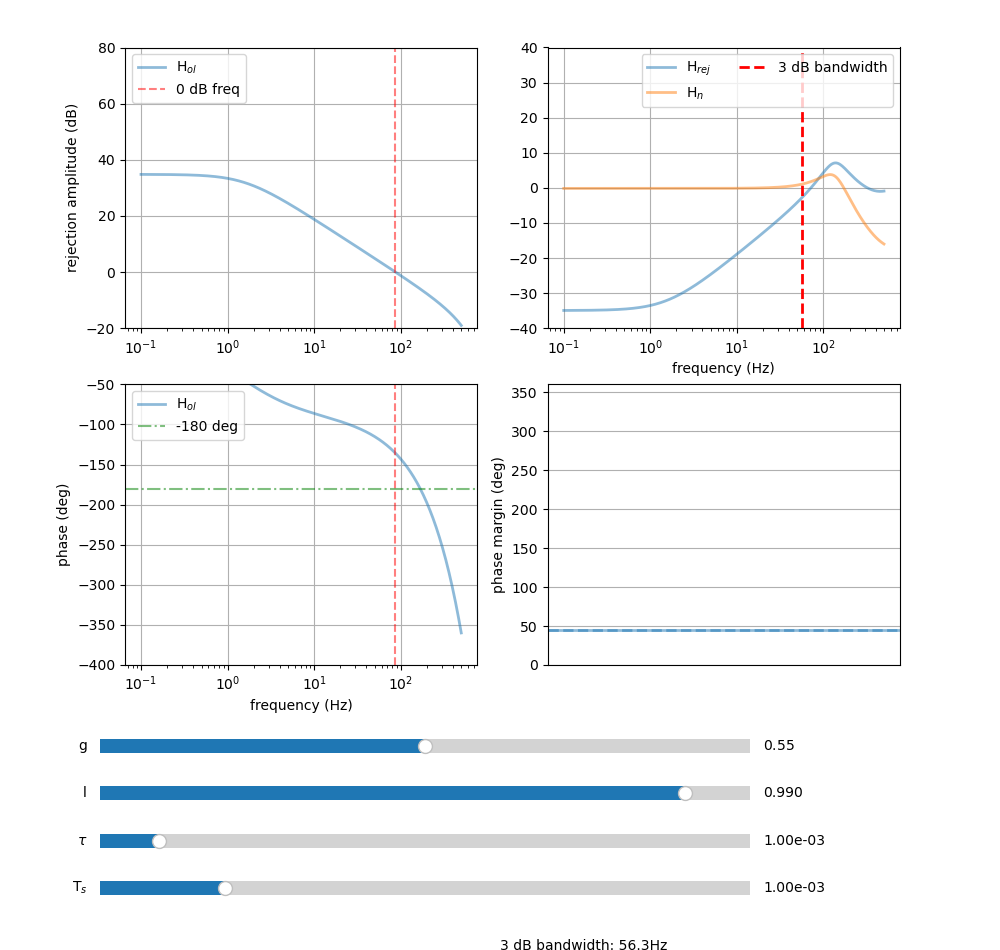

In [1]:
%matplotlib widget

'''
gui for AO transfer functions
'''

from matplotlib.widgets import Slider, Button, RadioButtons
import numpy as np
import matplotlib.pyplot as plt

#magnitude and phase of transfer functions:
mag = lambda tf: 20.*np.log10(np.sqrt(np.real(tf)**2.+np.imag(tf)**2.)) #magnitude in dB
phase = lambda tf: np.unwrap(np.arctan2(np.imag(tf),np.real(tf)))*180./np.pi #np.unwrap prevents 2 pi phase discontinuities
s2f = lambda f: 1.j*2.*np.pi*f

#transfer functions
Hwfs = lambda s, Ts: (1. - np.exp(-Ts*s))/(Ts*s)
Hzoh=Hwfs
Hlag = lambda s,tau: np.exp(-tau*s)
Hcont = lambda s, Ts, g, l: g/(1. - l*np.exp(-Ts*s)) #leaky integrator
#DM*=L*DM_{N-1}+G*DM_N+X*DM{N-2}
Holsplane = lambda s, Ts, tau, g, l:  Hwfs(s, Ts)*Hlag(s,tau)*Hcont(s,Ts,g,l)*Hzoh(s,Ts)
Hol = lambda f, Ts, tau, g, l:  Holsplane(1.j*2.*np.pi*f,Ts,tau,g,l)
Hrej = lambda f, Ts, tau, g, l: 1./(1. + Hol(f, Ts, tau, g, l))
Hn = lambda f, Ts, tau, g, l: Hol(f, Ts, tau, g, l)*Hrej(f, Ts, tau, g, l)/Hwfs(1.j*2.*np.pi*f, Ts)

#define initial conditions
freq = lambda Ts: np.logspace(np.log10(0.1),np.log10(1./(2*Ts)),500) #only plot up to the Nyquist limit 

g,l,Ts,tau=0.55,0.99,1e-3,1e-3
#f=np.logspace(np.log10(0.1),np.log10(1./(Ts*2.)),500) #only plot up to the Nyquist limit 
f=freq(Ts)

magol=mag(Hol(f,Ts,tau,g,l))
ind_margin=np.where(np.abs(magol)==np.min(np.abs(magol))) #this is where the tranfer function is 1
zerof=f[ind_margin]
phol=phase(Hol(f,Ts,tau,g,l))


fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,9.5))
ax1,ax2,ax3,ax4=axes[0,0],axes[1,0],axes[0,1],axes[1,1]

#ax1.set_xlabel('frequency (Hz)')
ax1.set_ylabel('rejection amplitude (dB)')
[line_ol]=ax1.plot(f,magol,lw=2,alpha=0.5,label='H$_{ol}$')
zero_ol=ax1.axvline(zerof,alpha=0.5,color='red',linestyle='--',label='0 dB freq')
ax1.set_xscale('log')
ax1.legend(loc='best')
ax1.set_ylim(-20,80)
ax1.grid('on')

#ax2 = fig.add_subplot(221)
ax2.set_xlabel('frequency (Hz)')
ax2.set_ylabel('phase (deg)')
ax2.set_ylim(-400,-50)

[line_ol_phase]=ax2.plot(f,phol,lw=2,alpha=0.5,label='H$_{ol}$')
zero_ol_phase=ax2.axvline(zerof,alpha=0.5,color='red',linestyle='--')
ax2.axhline(-180,alpha=0.5,color='green',linestyle='-.',label='-180 deg')
ax2.legend(loc='best')
ax2.set_xscale('log')
ax2.grid('on')


#ax3 = fig.add_subplot(212)
ax3.set_xlabel('frequency (Hz)')
#ax3.set_ylabel('rejection amplitude (dB)',labelpad=-5)

def plot2(f,tf,label):
	[line] = ax3.plot(f, tf, linewidth=2,label=label,alpha=0.5)
	ax3.set_xscale('log')
	return line

phrej=mag(Hrej(f,Ts,tau,g,l))
print(np.max(np.abs(phrej)))
line_rej=plot2(f,phrej,'H$_{rej}$')
line_n=plot2(f,mag(Hn(f,Ts,tau,g,l)),'H$_{n}$')
################################## should this be 3????#############################
threshold=3
####################################################################################
zerodb=np.min(f[np.where(np.abs(phrej)<threshold)]) #zero dB bandwidth: lowestfrequency at which the rejection transfer function crosses 0 dB
line_0db=ax3.axvline(zerodb,lw=2,color='red',ls='--',label=f'3 dB bandwidth')
ax3.legend(loc='best',ncol=2)
ax3.set_ylim(-40,40)
ax3.grid('on')

#ax4 = fig.add_subplot(222)
#ax4.set_xlabel('gain')
ax4.set_xticks([])
ax4.set_ylabel('phase margin (deg)')
ax4.axhline(45.,linestyle='--',lw=2,alpha=0.5)
ax4.set_ylim(0.,360.)
ax4.grid('on')

phase_margin=ax4.axhline(phol[ind_margin]+180.,lw=2,alpha=0.5)

# Add slider
fig.subplots_adjust(bottom=0.3,top=0.95)
gslider_ax  = fig.add_axes([0.1, 0.2, 0.65, 0.03])
gslider = Slider(gslider_ax, 'g', 0.1, 1.0, valinit=g)
lslider_ax  = fig.add_axes([0.1, 0.15, 0.65, 0.03])
lslider = Slider(lslider_ax, 'l', 0.9, 1.0, valinit=l,valfmt='%.3f')
tauslider_ax = fig.add_axes([0.1,0.1,0.65,0.03])
tauslider=Slider(tauslider_ax,'$\\tau$',1e-4,10e-3,valinit=tau,valfmt='%.2e')
tsslider_ax = fig.add_axes([0.1,0.05,0.65,0.03])
tsslider=Slider(tsslider_ax,'T$_s$',0.5e-4,5e-3,valinit=Ts,valfmt='%.2e')

# add text
zerodb_txt = fig.text(0.5, 0, f'3 dB bandwidth: {zerodb:.1f}Hz')

def sliders_on_changed(val):
	g=gslider.val
	l=lslider.val
	tau=tauslider.val
	Ts=tsslider.val
	f=freq(Ts)

	magol=mag(Hol(f,Ts,tau,g,l))
	phol=phase(Hol(f,Ts,tau,g,l))
	ind_margin=np.where(np.abs(magol)==np.min(np.abs(magol)))
	zerof=f[ind_margin]

	line_ol.set_ydata(magol)
	zero_ol.set_xdata(np.atleast_1d(zerof)) ######### added np.atleast_1d()

	line_ol_phase.set_ydata(phol)
	zero_ol_phase.set_xdata(np.atleast_1d(zerof)) ####### added np.atleast_1d()

	phrej=mag(Hrej(f,Ts,tau,g,l))
	line_rej.set_ydata(phrej)
	line_n.set_ydata(mag(Hn(f,Ts,tau,g,l)))
	zerodb=np.min(f[np.where(np.abs(phrej)<threshold)])
	line_0db.set_xdata(np.atleast_1d(zerodb)) ######## added np.atleast_1d()


	phase_margin.set_ydata(phol[ind_margin]+180.)

	# add update text
	zerodb_txt.set_text(f'__ dB bandwidth: {zerodb:.1f}Hz')

	fig.canvas.draw_idle()

gslider.on_changed(sliders_on_changed)
lslider.on_changed(sliders_on_changed)
tauslider.on_changed(sliders_on_changed)
tsslider.on_changed(sliders_on_changed)